In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install timm

# DataLOADER to load data from Dateset

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class NPYDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))  # ['no', 'sphere', 'vortex']
        self.class_to_idx = {'no': 0, 'sphere': 1, 'vort': 2}
        self.samples = []

        
        # Collect all .npy files with labels
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for file in os.listdir(cls_dir):
                if file.endswith('.npy'):
                    self.samples.append((
                        os.path.join(cls_dir, file),
                        self.class_to_idx[cls]
                    ))
        self.transform = transform


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        data = np.load(path).astype(np.float32)  # Shape: (1, 150, 150)
        
        # Remove batch dimension and add channel dimension
        data = np.squeeze(data)  # Shape: (150, 150)
        data = np.expand_dims(data, axis=0)  # Shape: (1, 150, 150)
        
        # Convert to PyTorch tensor
        data = torch.from_numpy(data)
        
        if self.transform:
            data = self.transform(data)
        return data, label


In [2]:
from torchvision import transforms

# Training transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),  # rotations up to 90 degrees
])


In [3]:
# Load datasets
train_dataset = NPYDataset('/kaggle/input/deeplense/dataset/train', transform=transform)
val_dataset = NPYDataset('/kaggle/input/deeplense/dataset/val', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


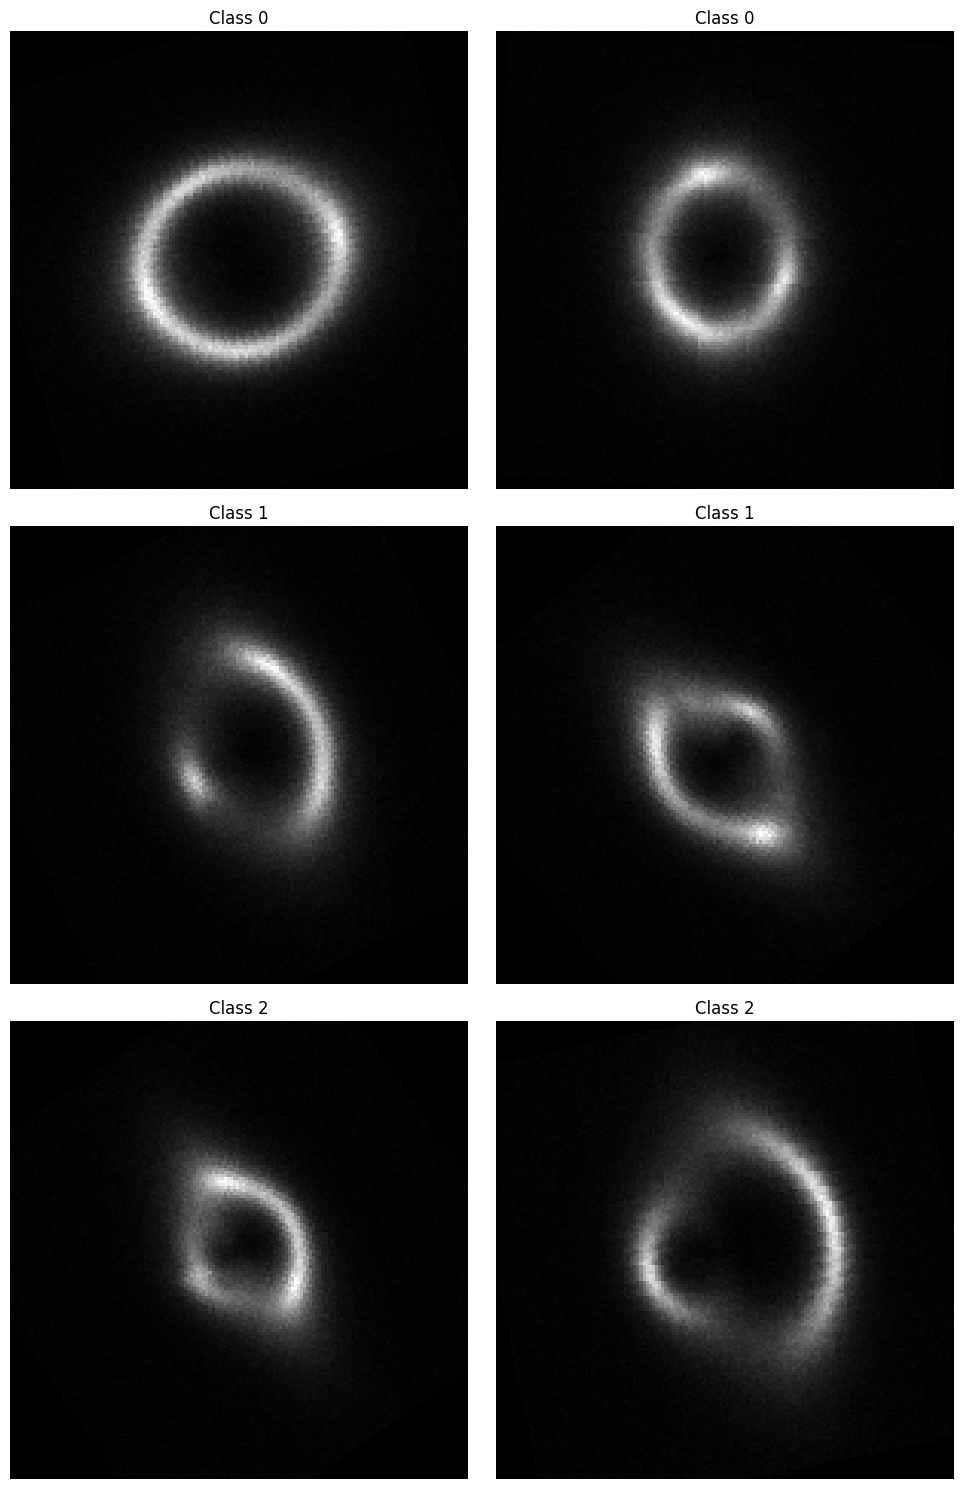

In [4]:
import matplotlib.pyplot as plt

# Create a dictionary to hold the first 2 indices for each class
class_indices = {}
for idx, (_, label) in enumerate(train_dataset.samples):
    if label not in class_indices:
        class_indices[label] = []
    if len(class_indices[label]) < 2:
        class_indices[label].append(idx)

# Collect the indices in order of class (e.g., class 0, then 1, then 2)
selected_indices = []
for label in sorted(class_indices.keys()):
    selected_indices.extend(class_indices[label])

# Create a subplot grid: one row per class (3 rows), 2 columns per row
fig, axes = plt.subplots(len(class_indices), 2, figsize=(10, 15))

for i, idx in enumerate(selected_indices):
    img, label = train_dataset[idx]
    row = i // 2
    col = i % 2
    axes[row, col].imshow(img.squeeze(), cmap='gray')
    axes[row, col].set_title(f"Class {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()



# Backbone Timm MODEL for lens Classification

In [5]:
import torch
import torch.nn as nn
import timm

class TimmModelComplex(nn.Module):
    """
    Complex Timm Model for Lens Classification

    This model uses a Timm backbone for feature extraction and a custom multi-layer
    classifier for classifying images into lens categories.
    
    Parameters:
    - name (str): Name of the Timm model (e.g., 'resnet18', 'efficientnet_b0', etc.)
    - in_chans (int): Number of input channels (e.g., 1 for grayscale images)
    - num_classes (int): Number of lens classes to classify
    - pretrained (bool): Whether to load pretrained weights (default: True)
    - tune (bool): If True, the whole backbone is fine-tuned; otherwise, only the classifier is trained
    - dropout_rate (float): Dropout rate used in the classifier (default: 0.5)
    """
    def __init__(self, name, in_chans=1, num_classes=3, pretrained=True, tune=True, dropout_rate=0.5):
        super().__init__()
        # Create the backbone without its classifier (num_classes=0 removes the default classifier)
        self.backbone = timm.create_model(name, pretrained=pretrained, in_chans=in_chans, num_classes=0)
        
        # Freeze backbone parameters if not tuning the whole network
        for param in self.backbone.parameters():
            param.requires_grad = tune
        
        # Determine feature dimension from the backbone
        # Many timm models have a 'num_features' attribute
        feature_dim = self.backbone.num_features
        
        # Define a complex classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim, 1024),
            nn.PReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
    

    def forward(self, x):
        # Extract features using the backbone
        features = self.backbone.forward_features(x)
        # Apply adaptive average pooling to reduce the spatial dimensions to 1x1
        pooled_features = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        # Flatten the pooled features; shape becomes (batch_size, 512)
        flattened = pooled_features.view(pooled_features.size(0), -1)
        # Pass through the custom classifier
        out = self.classifier(flattened)
        return out


model = TimmModelComplex(name="efficientnet_b0", in_chans=1, num_classes=3, pretrained=True, tune=True, dropout_rate=0.5)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Model Trainning 

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if CUDA is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the complex Timm model for lens classification
# Replace 'resnet18' with your desired timm model architecture if needed.
model = TimmModelComplex(name="efficientnet_b0", in_chans=1, num_classes=3, pretrained=True, tune=True, dropout_rate=0.5)
model.to(device)

# Define loss function and optimizer
best_auc = 0.0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training loop
for epoch in range(30):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())  # Move to CPU before converting to NumPy
            y_pred.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    print(f"Epoch {epoch}, Val AUC: {auc:.4f}")

    # Save best model if performance meets threshold
    if auc > 0.9:
        best_auc = auc
        torch.save(model.state_dict(), 'E_model.pth')

    # Early stopping (optional)
    if epoch > 10 and auc < 0.4:
         print("Stopping early due to poor performance.")
         break



# Model Evaluation 

**import trained model**

In [7]:
from IPython.display import FileLink

FileLink('/kaggle/working/E_model.pth')

/kaggle/working/E_model.pth

In [8]:
import torch
model = TimmModelComplex(name="efficientnet_b0", in_chans=1, num_classes=3, pretrained=True, tune=True, dropout_rate=0.5)
model.load_state_dict(torch.load('/kaggle/working/E_model.pth'))

<ipython-input-8-ddfa288d7977>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/E_model.pth'))


<All keys matched successfully>

*statistical inferencing*

In [9]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Validation phase
y_true = []  # Ground truth labels
y_pred = []  # Predicted probabilities

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        y_true.extend(labels.cpu().numpy())  # Move labels to CPU before converting to NumPy
        y_pred.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Move predictions to CPU

# Convert y_true to one-hot encoding
num_classes = 3  # Adjust based on your dataset
y_true_onehot = np.eye(num_classes)[y_true]  # Shape: [num_samples, num_classes]

# Compute AUC for each class (One-vs-Rest)
auc_scores = []
for i in range(num_classes):
    auc = roc_auc_score(y_true_onehot[:, i], np.array(y_pred)[:, i])
    auc_scores.append(auc)
    print(f"Class {i} AUC: {auc:.4f}")

# Average AUC
mean_auc = np.mean(auc_scores)
print(f"Mean AUC: {mean_auc:.4f}")


Class 0 AUC: 0.9876
Class 1 AUC: 0.9728
Class 2 AUC: 0.9866
Mean AUC: 0.9823


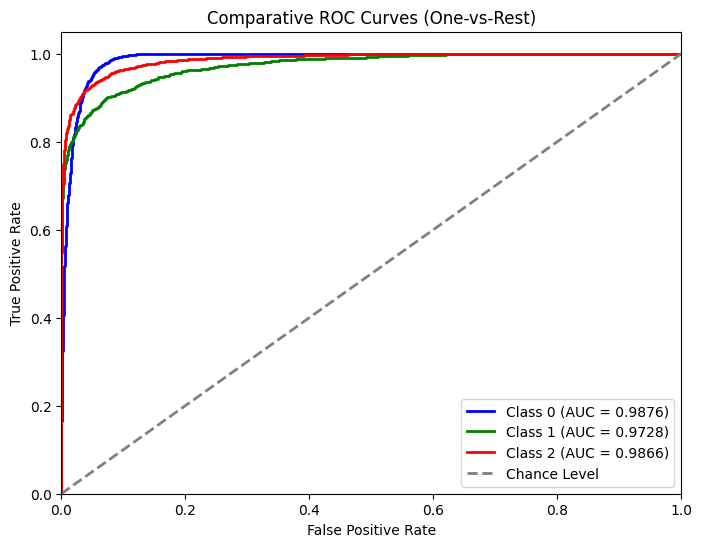

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming y_true_onehot and y_pred are computed from your validation phase
# y_true_onehot: shape [num_samples, num_classes]
# y_pred: shape [num_samples, num_classes]

num_classes = 3  # Update if needed
colors = ['blue', 'green', 'red']

plt.figure(figsize=(8, 6))
ax = plt.gca()

for i in range(num_classes):
    # Compute False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], np.array(y_pred)[:, i])
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color=colors[i], lw=2,
            label=f'Class {i} (AUC = {roc_auc:.4f})')

# Plot the chance line
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2, label='Chance Level')

# Set plot details
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Comparative ROC Curves (One-vs-Rest)")
ax.legend(loc="lower right")
plt.show()


In [11]:

from torchvision import transforms

transform = transforms.Compose([
])

# Create dataset for validation
val_dir = "/kaggle/input/deeplense/dataset/val"
val_dataset_full = NPYDataset(root_dir=val_dir, transform=transform)

# 90:10 split into val and test sets
val_size = int(0.9 * len(val_dataset_full))
test_size = len(val_dataset_full) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset_full, [val_size, test_size])

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load the best model weights if needed
model.load_state_dict(torch.load('E_model.pth', weights_only=True))

model.to(device)
model.eval()

# Testing phase: Evaluate performance on the test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader is your DataLoader for test data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Get predicted class (argmax over the logits)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Also store probabilities for ROC-AUC
        probabilities = torch.softmax(outputs, dim=1)
        all_probs.extend(probabilities.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate Accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Compute multi-class ROC-AUC (One-vs-Rest)
num_classes = 3
all_labels_onehot = np.eye(num_classes)[all_labels]
auc = roc_auc_score(all_labels_onehot, all_probs, multi_class='ovr')
print(f"Test ROC-AUC: {auc:.4f}")


Test Accuracy: 0.9120
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       241
           1       0.87      0.89      0.88       248
           2       0.97      0.91      0.94       261

    accuracy                           0.91       750
   macro avg       0.91      0.91      0.91       750
weighted avg       0.91      0.91      0.91       750

Confusion Matrix:
[[225  14   2]
 [ 21 221   6]
 [  3  20 238]]
Test ROC-AUC: 0.9857


Test Accuracy: 0.9120
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       241
           1       0.87      0.89      0.88       248
           2       0.97      0.91      0.94       261

    accuracy                           0.91       750
   macro avg       0.91      0.91      0.91       750
weighted avg       0.91      0.91      0.91       750

Confusion Matrix:
[[225  14   2]
 [ 21 221   6]
 [  3  20 238]]
Test ROC-AUC: 0.9857


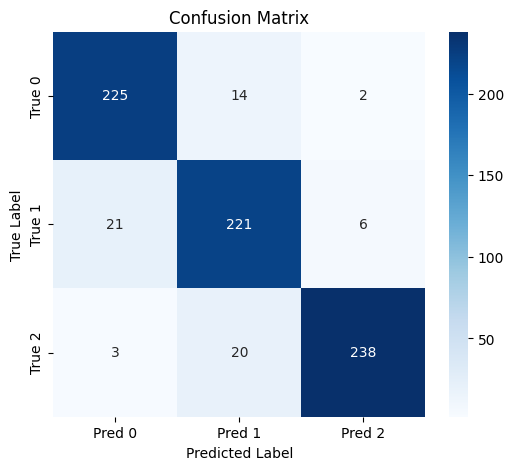

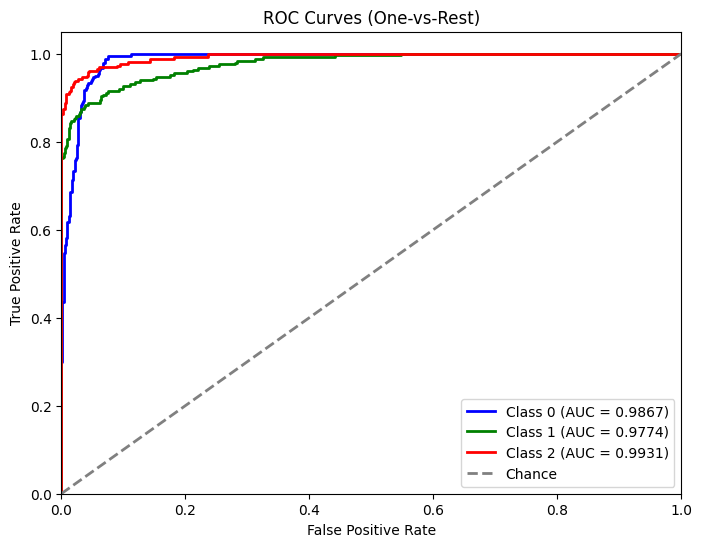

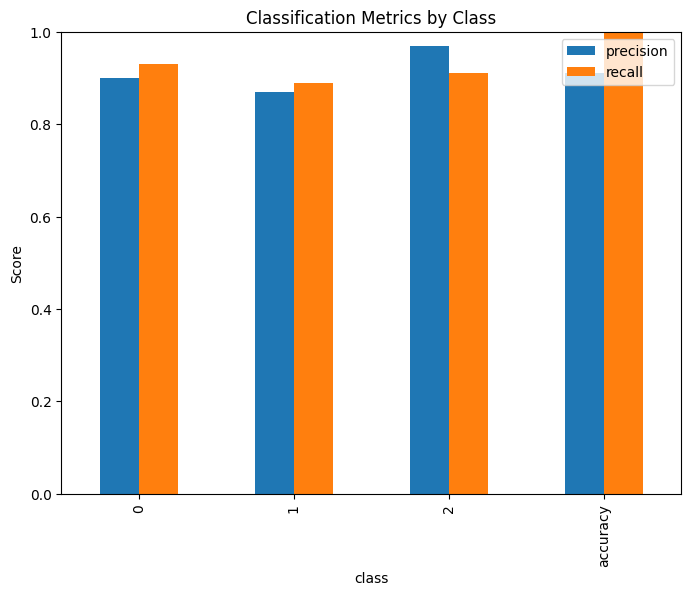

In [13]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model weights if needed
model.load_state_dict(torch.load('E_model.pth', weights_only=True))
model.to(device)
model.eval()

# Testing phase: Evaluate performance on the test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader is your DataLoader for test data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Get predicted class (argmax over the logits)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Also store probabilities for ROC-AUC
        probabilities = torch.softmax(outputs, dim=1)
        all_probs.extend(probabilities.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate Accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Compute multi-class ROC-AUC (One-vs-Rest)
num_classes = 3
all_labels_onehot = np.eye(num_classes)[all_labels]
auc_score = roc_auc_score(all_labels_onehot, all_probs, multi_class='ovr')
print(f"Test ROC-AUC: {auc_score:.4f}")

# -----------------------------------
# Visualization Section
# -----------------------------------

# 1. Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Pred {i}" for i in range(num_classes)],
            yticklabels=[f"True {i}" for i in range(num_classes)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 2. Plot ROC Curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i in range(num_classes):
    # Calculate ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

# 3. Optionally, plot a bar chart for precision, recall, and f1-score for each class.
# Extracting metrics from the classification report
import pandas as pd
from io import StringIO

# Parse the classification report into a DataFrame
report_data = []
lines = report.split('\n')
for line in lines[2:(len(lines)-3)]:
    row = {}
    tokens = line.split()
    if len(tokens) < 2: continue
    row['class'] = tokens[0]
    row['precision'] = float(tokens[1])
    row['recall'] = float(tokens[2])

    report_data.append(row)
df = pd.DataFrame.from_dict(report_data)

df.set_index('class', inplace=True)
df[['precision','recall']].plot(kind='bar', figsize=(8,6))
plt.title("Classification Metrics by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


Test Accuracy: 0.9120
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       241
           1       0.87      0.89      0.88       248
           2       0.97      0.91      0.94       261

    accuracy                           0.91       750
   macro avg       0.91      0.91      0.91       750
weighted avg       0.91      0.91      0.91       750

Confusion Matrix:
[[225  14   2]
 [ 21 221   6]
 [  3  20 238]]
Test ROC-AUC: 0.9857


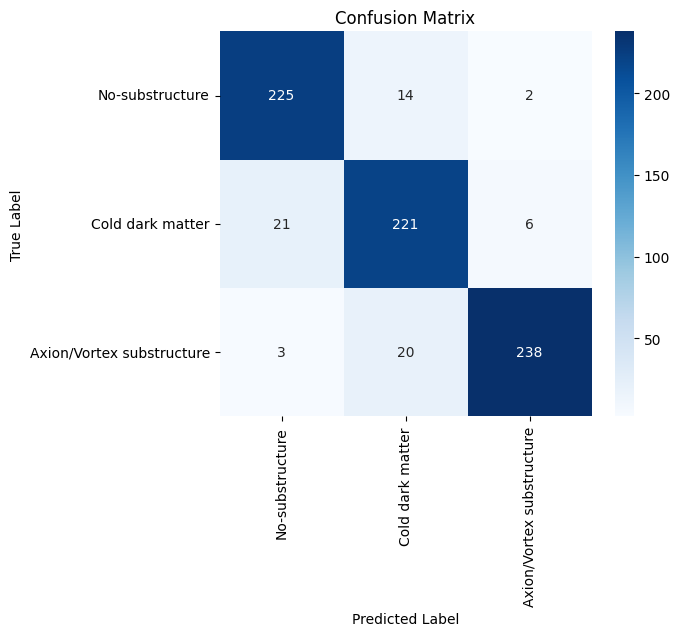

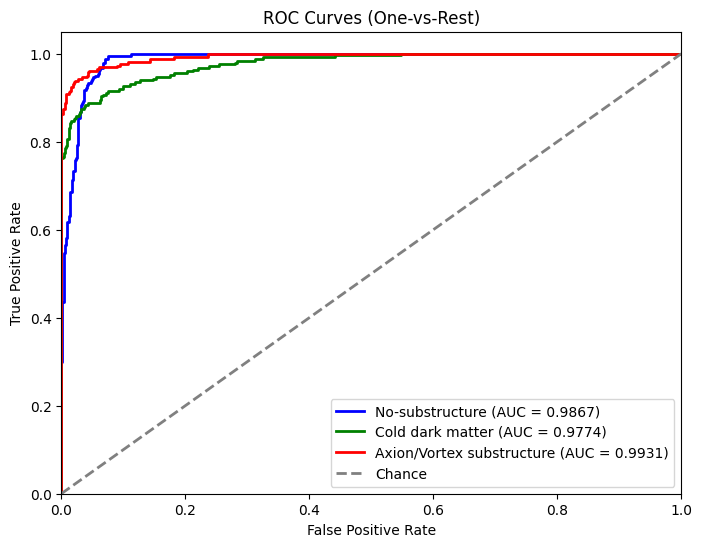

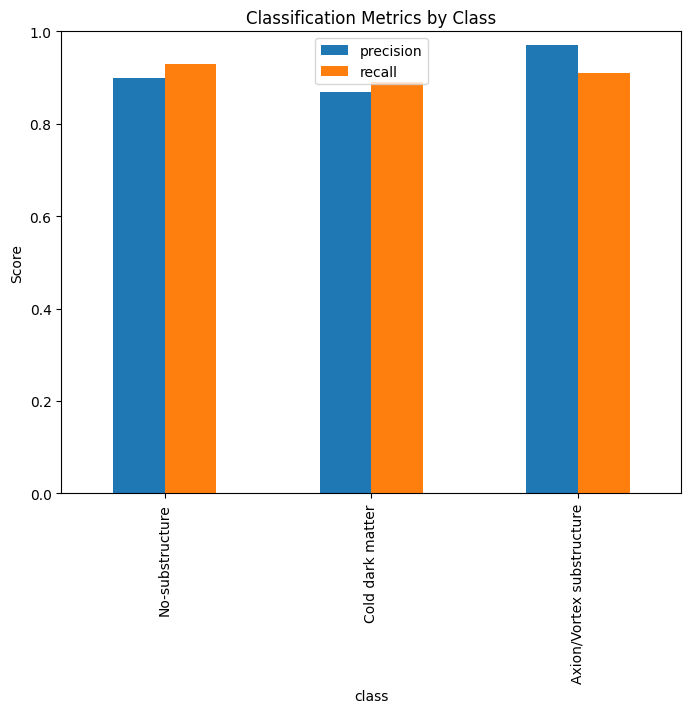

In [14]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from io import StringIO

# Define custom class names
class_names = ["No-substructure", "Cold dark matter", "Axion/Vortex substructure"]

# Load the best model weights if needed
model.load_state_dict(torch.load('E_model.pth', weights_only=True))
model.to(device)
model.eval()

# Testing phase: Evaluate performance on the test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader is your DataLoader for test data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Get predicted class (argmax over the logits)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Also store probabilities for ROC-AUC
        probabilities = torch.softmax(outputs, dim=1)
        all_probs.extend(probabilities.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate Accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Compute multi-class ROC-AUC (One-vs-Rest)
num_classes = len(class_names)
all_labels_onehot = np.eye(num_classes)[all_labels]
auc_score = roc_auc_score(all_labels_onehot, all_probs, multi_class='ovr')
print(f"Test ROC-AUC: {auc_score:.4f}")

# -----------------------------------
# Visualization Section
# -----------------------------------

# 1. Plot Confusion Matrix as a Heatmap with custom labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 2. Plot ROC Curves for each class with custom labels
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i in range(num_classes):
    # Calculate ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

# 3. Plot a bar chart for precision and recall for each class with custom labels
# Parse the classification report into a DataFrame, ignoring non-numeric rows
report_data = []
lines = report.split('\n')
for line in lines[2:(len(lines)-3)]:
    tokens = line.split()
    if len(tokens) < 2:
        continue
    if not tokens[0].isdigit():  # Skip lines like "accuracy"
        continue
    row = {}
    class_idx = int(tokens[0])
    row['class'] = class_names[class_idx] if class_idx < len(class_names) else tokens[0]
    row['precision'] = float(tokens[1])
    row['recall'] = float(tokens[2])
    report_data.append(row)

df = pd.DataFrame.from_dict(report_data)
df.set_index('class', inplace=True)
df[['precision','recall']].plot(kind='bar', figsize=(8,6))
plt.title("Classification Metrics by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


# Results Visualization

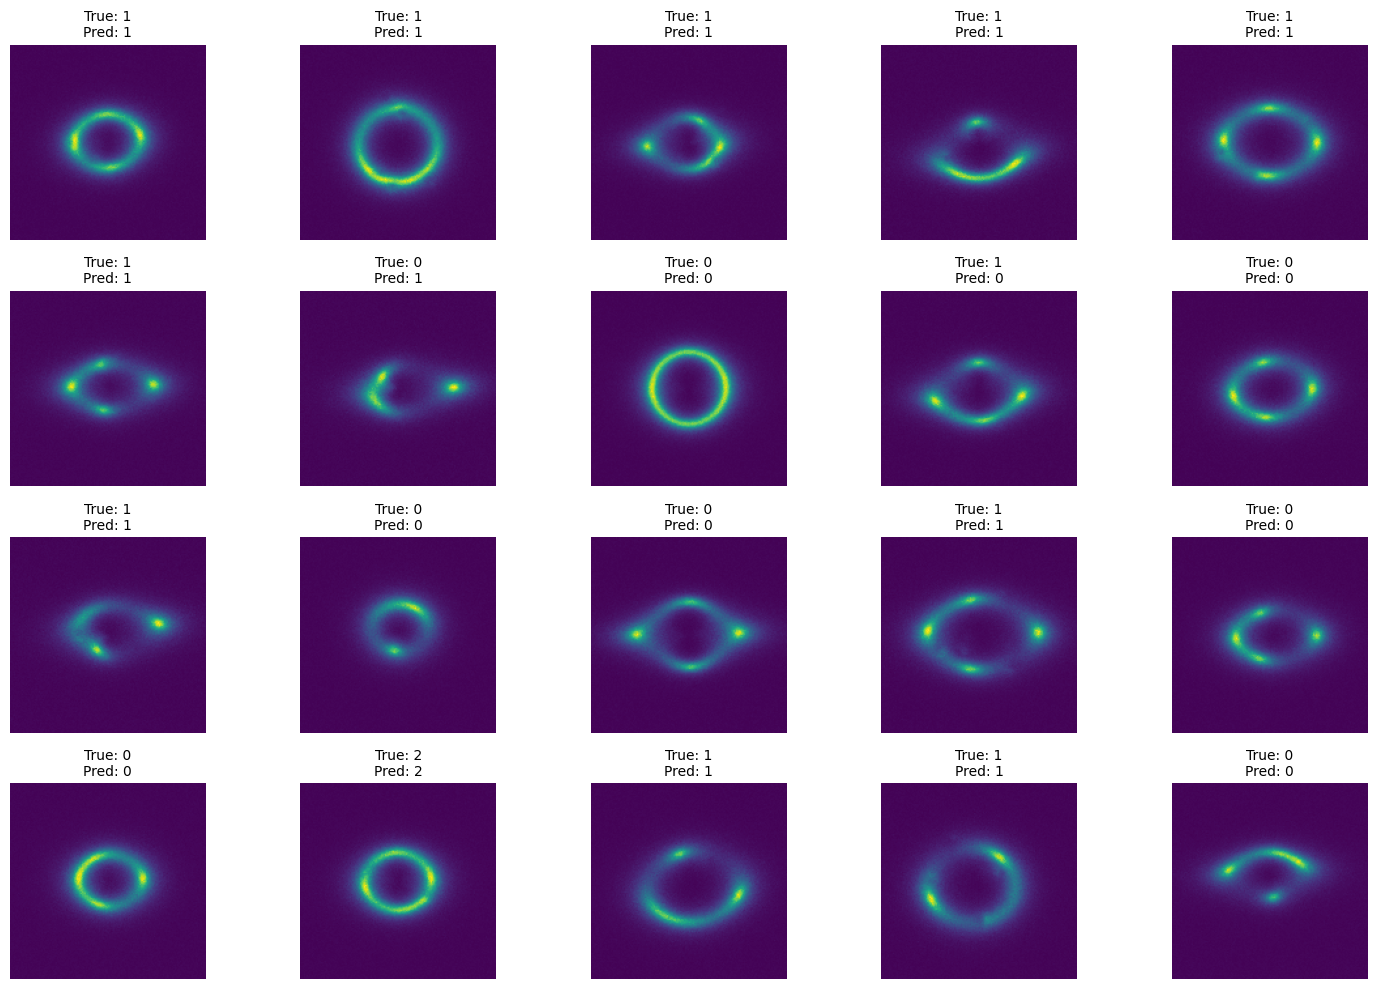

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Retrieve 20 test samples for visualization
sample_images = []
sample_preds = []
sample_true = []

# Iterate over test_loader to get enough samples
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        # Append images, predictions, and true labels
        for i in range(len(labels)):
            sample_images.append(inputs[i].cpu())
            sample_preds.append(preds[i].cpu().item())
            sample_true.append(labels[i].cpu().item())
        # Stop after collecting 20 samples
        if len(sample_images) >= 20:
            break

# Function to denormalize images (if needed)
def denormalize(img, mean, std):
    img = img.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization
    return img

# Denormalization parameters (adjust if different)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Plot 20 sample images in a 4x5 grid
num_samples = min(20, len(sample_images))
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_samples):
    # Denormalize and convert tensor to numpy array
    img = denormalize(sample_images[i], mean, std)
    img_np = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img_np = np.clip(img_np, 0, 1)  # Ensure values are in the correct range
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"True: {sample_true[i]}\nPred: {sample_preds[i]}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()



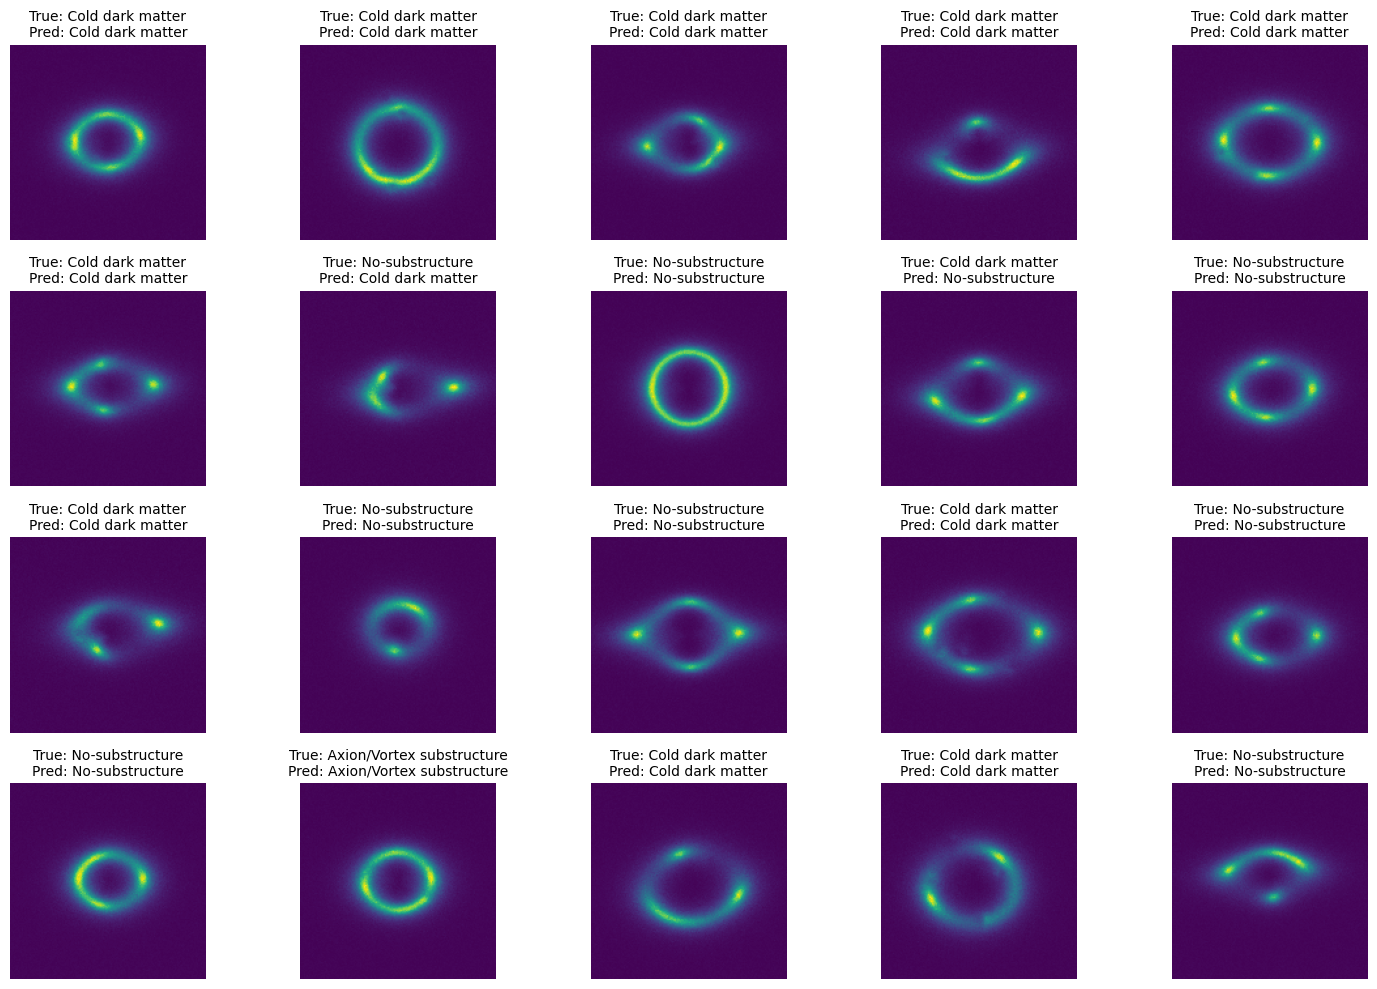

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
model = TimmModelComplex(name="efficientnet_b0", in_chans=1, num_classes=3, pretrained=True, tune=True, dropout_rate=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define custom labels for the classes
class_names = ["No-substructure", "Cold dark matter", "Axion/Vortex substructure"]

# Load your custom model weights and set the model to evaluation mode
# (Make sure 'custom_model.pth' is replaced with your actual model file)
model.load_state_dict(torch.load('E_model.pth', weights_only=True))
model.to(device)
model.eval()

# Retrieve 20 test samples for visualization
sample_images = []
sample_preds = []
sample_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        # Append images, predictions, and true labels from the batch
        for i in range(len(labels)):
            sample_images.append(inputs[i].cpu())
            sample_preds.append(preds[i].cpu().item())
            sample_true.append(labels[i].cpu().item())
        if len(sample_images) >= 20:
            break

# Function to denormalize images (if needed)
def denormalize(img, mean, std):
    img = img.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization
    return img

# Denormalization parameters (adjust if different)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Plot 20 sample images in a 4x5 grid
num_samples = min(20, len(sample_images))
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_samples):
    # Denormalize and convert tensor to a NumPy array
    img = denormalize(sample_images[i], mean, std)
    img_np = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img_np = np.clip(img_np, 0, 1)  # Ensure values are in the correct range
    
    # Map numeric labels to custom labels
    true_label = class_names[sample_true[i]]
    pred_label = class_names[sample_preds[i]]
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()
